In [1]:
from datetime import date, timedelta
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
from matplotlib.colors import Normalize
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

def get_rid_of_shit(x:str):
    arr = x.split(",")[:-1]
    return arr[0]+","+arr[1]
correct = np.vectorize(get_rid_of_shit)

months = ['Jan','Feb','Mar','Apr','Mai','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# Define the date range to retrieve data for
start_date = str(date.today()-timedelta(days=5*365))
end_date = str(date.today())

# Dividend Settings
month_period = 6

def create_plot_tickers(tickers,syms):
    # Retrieve the stock data for each ticker and merge them into a single dataframe
    dfs = [ticker.history(start=start_date, end=end_date, interval='1mo') for ticker in tickers]

    all_total_return, all_dividends, all_stock_prices, all_stock_peRatio = [list(),list(),list(),list()]
    for ticker,df in zip(tickers,dfs):
        # fill NaN values with previous row values
        df['Close'] = df['Close'].fillna(method='ffill').fillna(method='bfill')
        df['Dividends'] = df['Dividends'].fillna(0)


        ## simple yearly
        #X = df['Close'].iloc[:-12].to_numpy().reshape(-1, 1)  # use all but the last year as training data
        #y = df['Close'].iloc[12:].to_numpy()   # use all but the first year as target data
        #year_model = LinearRegression()
        #year_model.fit(X, y)
        #future_index = pd.date_range(date.today(), periods=12, freq='M')
        #future_year_preds = pd.DataFrame({'Date': future_index, 'Close': [year_model.predict(price.reshape(1, -1))[0] \
        #                                    for price in df['Close'].iloc[-12:].to_numpy()]}).set_index('Date')
        #monthly_close = pd.concat([df['Close'], future_year_preds['Close']])
        
        # Grab the dividends for each ticker
        #X = df['Dividends'].iloc[:-12].to_numpy().reshape(-1, 1)  # use all but the last year as training data
        #y = df['Dividends'].iloc[12:].to_numpy()   # use all but the first year as target data
        #year_model = LinearRegression()
        #year_model.fit(X, y)
        #future_index = pd.date_range(date.today(), periods=12, freq='M')
        #future_year_preds = pd.DataFrame({'Date': future_index, 'Dividends': [year_model.predict(price.reshape(1, -1))[0] \
        #                                    for price in df['Dividends'].iloc[-12:].to_numpy()]}).set_index('Date')
        #dividends = pd.concat([df['Dividends'], future_year_preds['Dividends']])


        # train a linear regression model to predict changes in stock price and dividends
        timings = [36,24,12,6,3]
        results = list()
        for tag in ['Close','Dividends']:
            # model at different pred depth
            model_zoo = list()
            for timing in timings:
                X = df[tag].iloc[:-timing].to_numpy().reshape(-1, 1)  # use all but the last year as training data
                y = df[tag].iloc[timing:].to_numpy()   # use all but the first year as target data
                model = LinearRegression()
                model.fit(X, y)
                model_zoo.append(model)

            # general model using all depths
            X = list()
            for it in range(max(timings),len(df[tag])):
                X.append([model_zoo[num].predict(df[tag].iloc[it-timings[num]].reshape(1, -1))[0] \
                          for num in range(len(model_zoo))])
            X = np.array(X)
            y = df[tag].iloc[max(timings):].to_numpy()
            model = LinearRegression()
            model.fit(X, y)

            # yearly predictions with general model
            monthly_close = df
            future_index = pd.date_range(date.today(), periods=12, freq='M')
            input_vec = [[model_zoo[num].predict(monthly_close[tag].iloc[-timings[num]+offset].reshape(1, -1))[0] \
                          for num in range(len(model_zoo))] for offset in range(12)]
            future_year_preds = pd.DataFrame({'Date': future_index, tag: model.predict(input_vec) }).set_index('Date')
            results.append(pd.concat([monthly_close[tag], future_year_preds[tag]]))
        monthly_close = results[0]
        monthly_close.index = pd.DatetimeIndex([str(date).split(" ")[0] for date in monthly_close.index])
        monthly_close.index.name = "Date"
        dividends = results[1]
        dividends.index = pd.DatetimeIndex([str(date).split(" ")[0] for date in dividends.index])
        dividends.index.name = "Date"

        # extract annual earnings and fill in NaNs
        earnings = None
        try: 
            earnings = ticker.earnings_history
            earnings["Date"] = pd.DatetimeIndex(correct(earnings["Earnings Date"]))
            earnings = earnings.set_index("Date")["Reported EPS"].fillna(method='ffill').fillna(method='bfill')
        except: 
            try:
                earnings = ticker.actions["Capital Gains"].fillna(method='ffill').fillna(method='bfill')
                earnings.index = pd.DatetimeIndex([str(date).split(" ")[0] for date in earnings.index])
                earnings.index.name = "Date"
            except:
                earnings = pd.DataFrame(np.ones(len(monthly_close)),index=monthly_close.index)[0]
        earnings = earnings[pd.to_datetime('now').year-5<=pd.DatetimeIndex(earnings.index).year]
        earnings = earnings[pd.DatetimeIndex(earnings.index).year<=pd.to_datetime('now').year]
        earnings = earnings[(pd.DatetimeIndex(earnings.index).month<=pd.to_datetime('now').month).__or__(pd.DatetimeIndex(earnings.index).year<pd.to_datetime('now').year)]
        
        # train a linear regression model to predict changes in earnings
        annual_earnings = earnings.groupby(pd.DatetimeIndex(earnings.index).year).first()

        # Calculate the monthly returns for each ticker
        monthly_returns = monthly_close.pct_change().replace(float('inf'), 0)

        # Calculate the cumulative growth for each ticker
        cumulative_growth = (1 + monthly_returns).cumprod()

        # Calculate the total return (growth + dividends) for each ticker
        total_return = cumulative_growth * (1 + dividends / monthly_close.shift(1).replace(0,1)).cumprod()

        all_dividends.append(dividends)
        all_total_return.append(total_return)
        all_stock_prices.append(monthly_close)
        all_stock_peRatio.append(pd.DataFrame(monthly_close.iloc[::12].to_numpy()/annual_earnings.clip(lower=1).to_numpy(),index=monthly_close.iloc[::12].index)[0])


    # Plot cumulative growth and dividends
    ax1  = plt.figure(1,figsize=(10, 8)).gca()
    ax2  = plt.figure(2,figsize=(10, 8)).gca()
    ax3  = plt.figure(3,figsize=(10, 8)).gca()
    ax4  = plt.figure(4,figsize=(10, 8)).gca()
    fig5 = plt.figure(5,figsize=(10, 8))
    ax5  = fig5.gca()
    ax6  = plt.figure(6,figsize=(10, 8)).gca()
    ax7  = plt.figure(7,figsize=(10, 8)).gca()

    all_stock_prices = pd.concat(all_stock_prices, axis=1, keys=syms).fillna(method='ffill').fillna(method='bfill')
    all_dividends = pd.concat(all_dividends, axis=1, keys=syms).fillna(0)
    all_stock_peRatio = pd.concat(all_stock_peRatio, axis=1, keys=syms).fillna(method='ffill').fillna(method='bfill')
    all_total_return = pd.concat(all_total_return, axis=1, keys=syms).fillna(method='ffill').fillna(method='bfill')*100
    corr_mat = all_stock_prices.corr()
    all_annual_yields = pd.DataFrame(((all_stock_prices.iloc[12::12].to_numpy()/all_stock_prices.iloc[:-12:12].to_numpy())-1)*100,
                                     columns=all_stock_prices.columns, index=all_stock_prices.iloc[12::12].index)
    all_annual_volatility = pd.DataFrame([(all_stock_prices.iloc[it*12:(it+1)*12].std().to_numpy()/all_stock_prices.iloc[(it+1)*12].to_numpy())*100 for it in range((len(all_stock_prices)//12)-1)],
                                     columns=all_stock_prices.columns, index=(all_stock_prices.iloc[12::12]).iloc[:(len(all_stock_prices)//12)-1].index)

    all_stock_prices.plot.line(ax=ax1)
    all_dividends.plot.bar(ax=ax2,stacked=True)
    all_stock_peRatio.plot.line(ax=ax3)
    all_total_return.plot.line(ax=ax4)
    sm.graphics.plot_corr(corr_mat,xnames=all_stock_prices.columns,ax=ax5,normcolor=(0,1),cmap=cm.get_cmap('jet'))
    fig5.colorbar(cm.ScalarMappable(norm=Normalize(vmin=0,vmax=1), cmap=cm.get_cmap('jet')), ax=ax5)
    all_annual_yields.plot.line(ax=ax6)
    all_annual_volatility.plot.line(ax=ax7)

    ax1.set_ylabel('Stock Price in $')
    ax2.set_ylabel('Dividends in $')
    ax3.set_ylabel('P/E-Ratio')
    ax4.set_ylabel('Total Return in %')
    ax5.set_title('Correlation of Tickers')
    ax6.set_ylabel('Annual Yield in %')
    ax7.set_ylabel('Annual Volatility in %')

    ax2.set_xticks(ax2.get_xticks()[::month_period], labels=[months[it%12] \
                    for it in range(0,len(ax2.get_xticks()),month_period)])
    ax1.axvspan(mdates.date2num(all_stock_prices.index[-12]),mdates.date2num(all_stock_prices.index[-1]), facecolor='green', alpha=0.2)
    ax2.axvspan(ax2.get_xticks()[-3]+(ax2.get_xlim()[-1]-ax2.get_xticks()[-1]), \
                ax2.get_xlim()[-1], facecolor='green', alpha=0.2)
    ax3.axvspan(mdates.date2num(all_stock_peRatio.index[-2]), mdates.date2num(all_stock_peRatio.index[-1]), facecolor='green', alpha=0.2)
    ax4.axvspan(mdates.date2num(all_total_return.index[-12]), mdates.date2num(all_total_return.index[-1]), facecolor='green', alpha=0.2)
    ax6.axvspan(mdates.date2num(all_annual_yields.index[-2]),mdates.date2num(all_annual_yields.index[-1]), facecolor='green', alpha=0.2)
    ax7.axvspan(mdates.date2num(all_annual_yields.index[-2]),mdates.date2num(all_annual_yields.index[-1]), facecolor='green', alpha=0.2)
    plt.show()

# Dividend ETFs

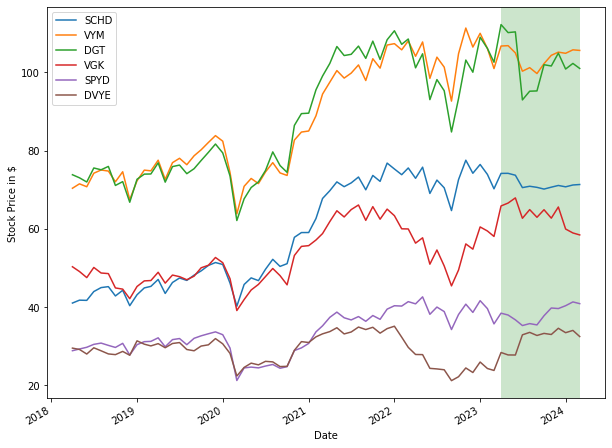

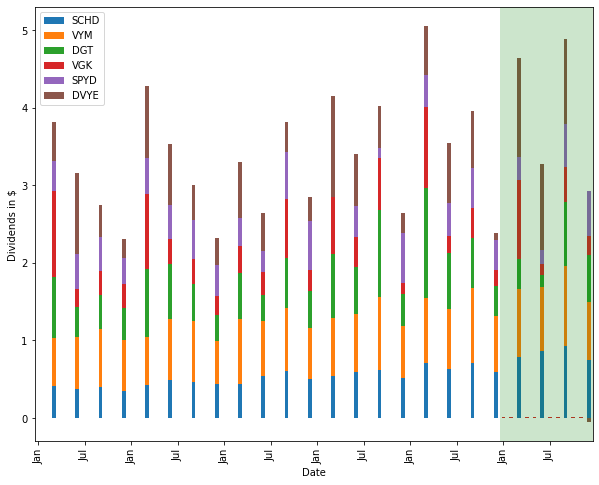

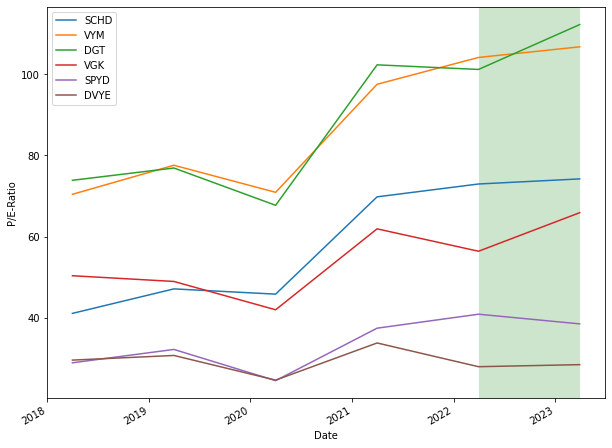

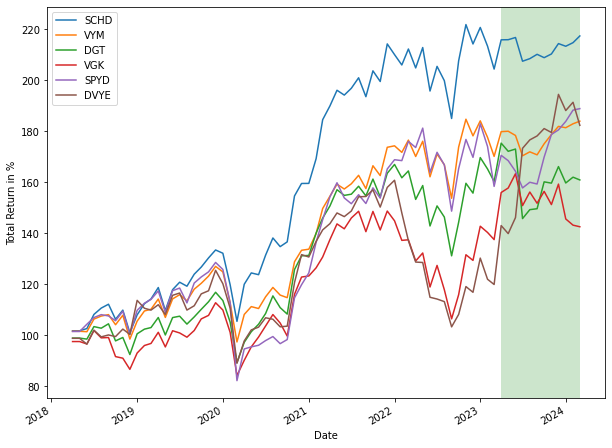

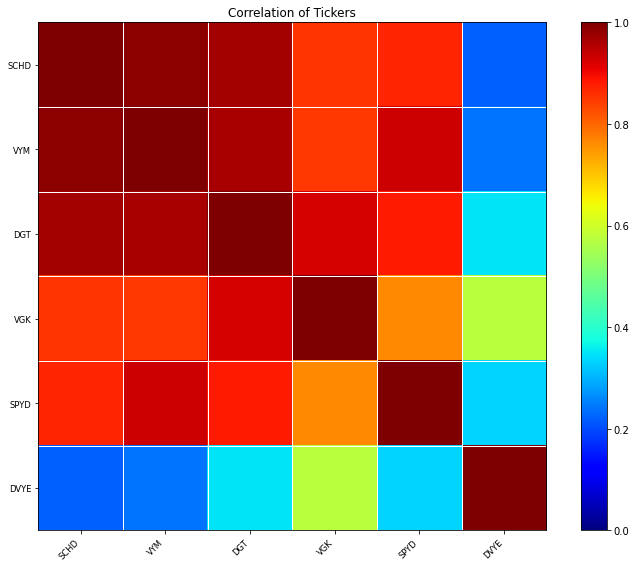

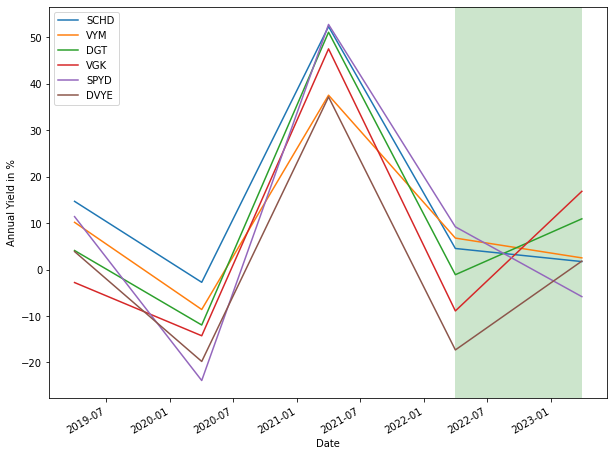

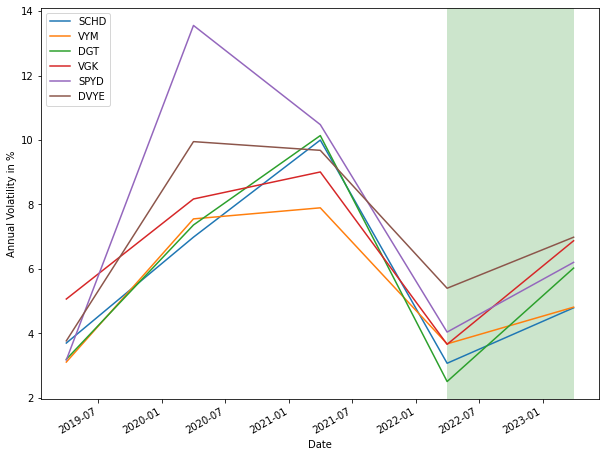

In [2]:
# Define the tickers to retrieve data for
syms = ['SCHD', 'VYM', 'DGT', 'VGK', 'SPYD', 'DVYE']
tickers = [yf.Ticker(sym) for sym in syms]

create_plot_tickers(tickers,syms)

# REITs

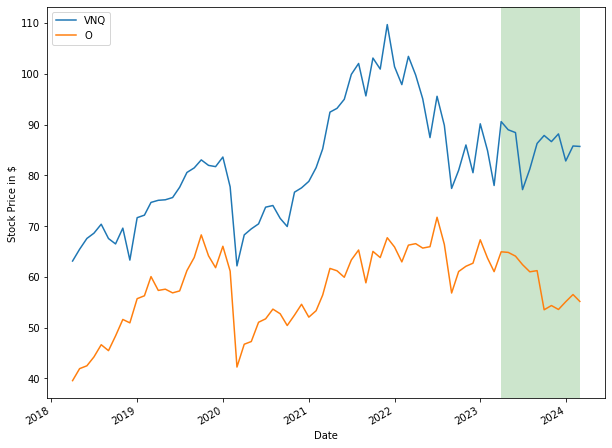

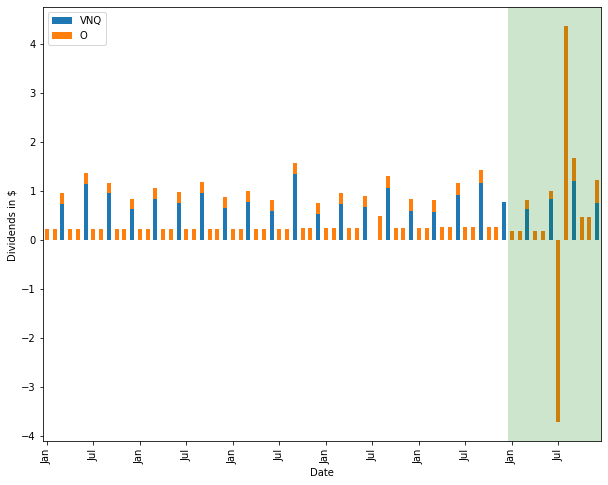

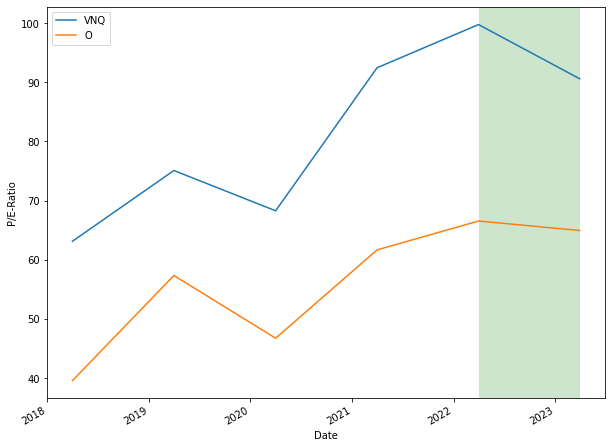

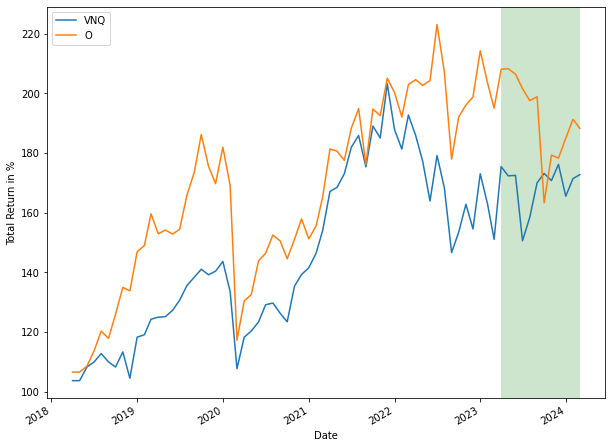

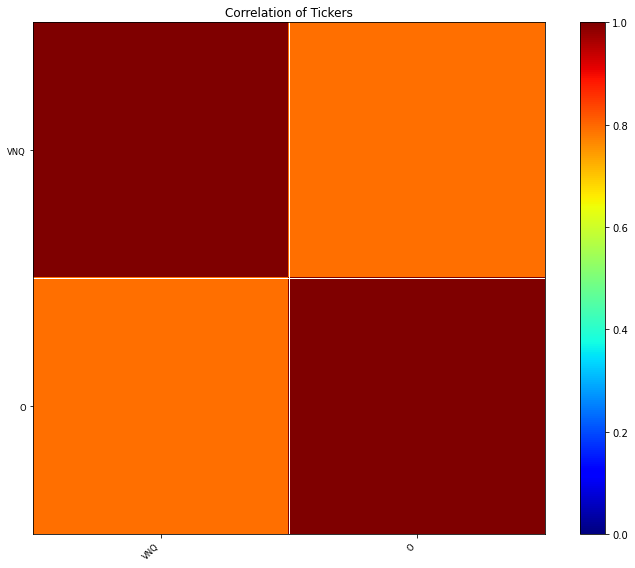

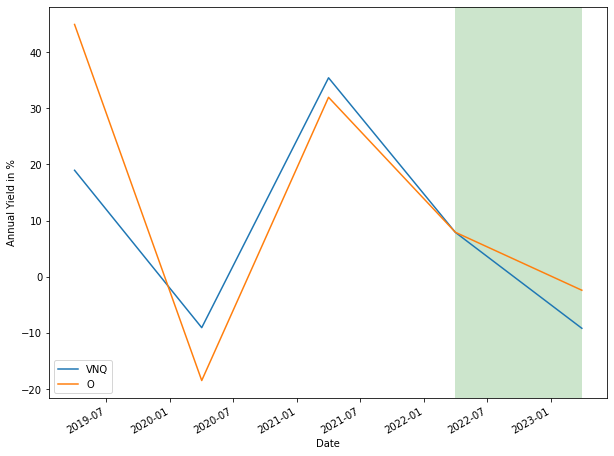

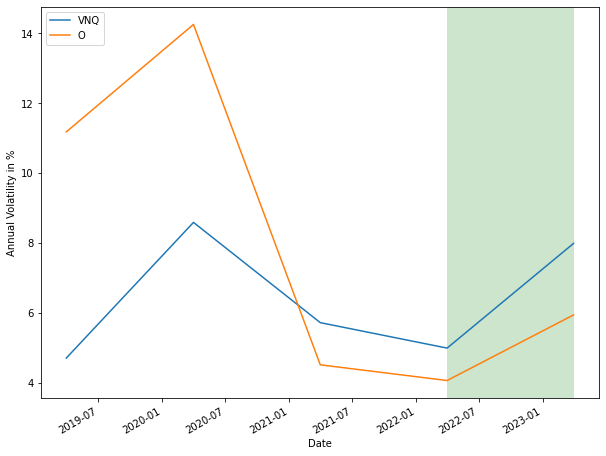

In [3]:
# Define the tickers to retrieve data for
syms = ['VNQ', 'O']
tickers = [yf.Ticker(sym) for sym in syms]

create_plot_tickers(tickers,syms)

# Stocks

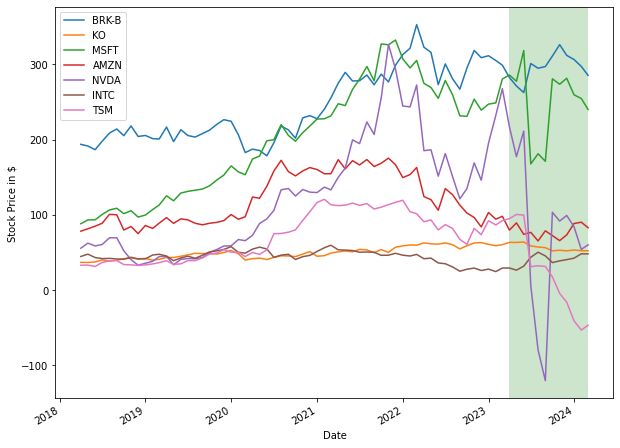

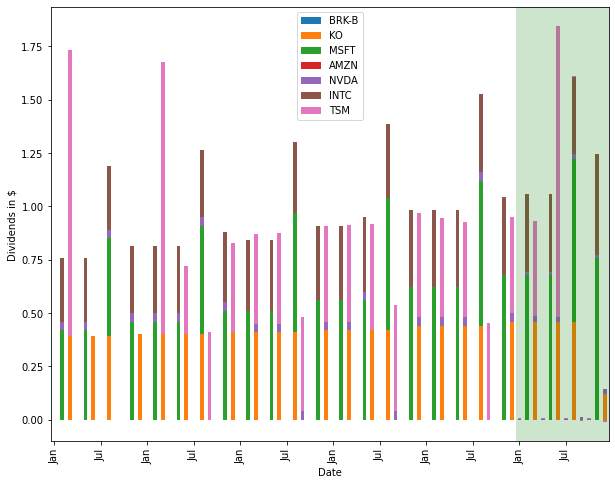

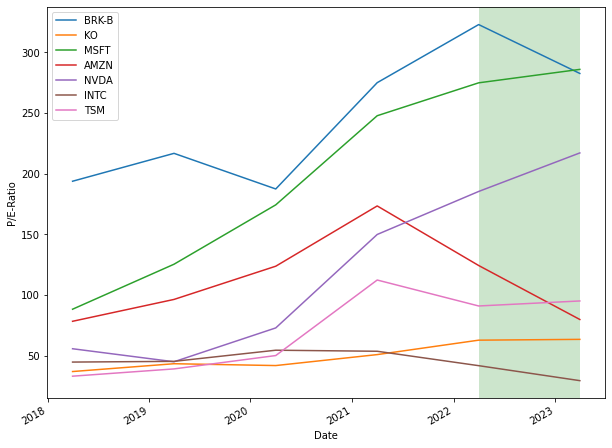

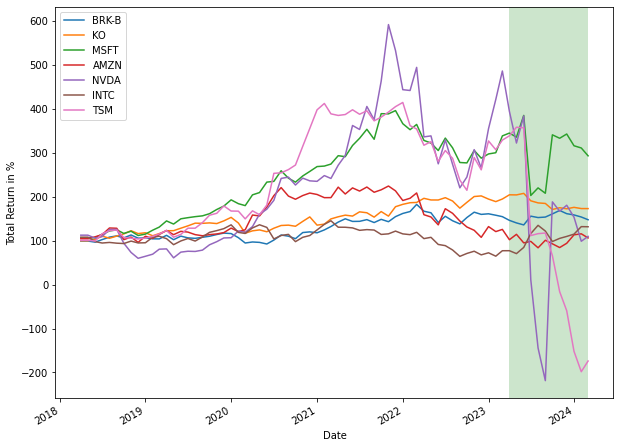

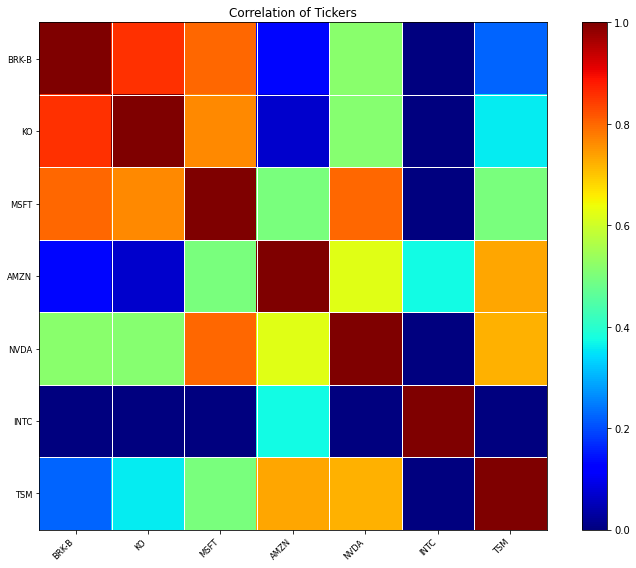

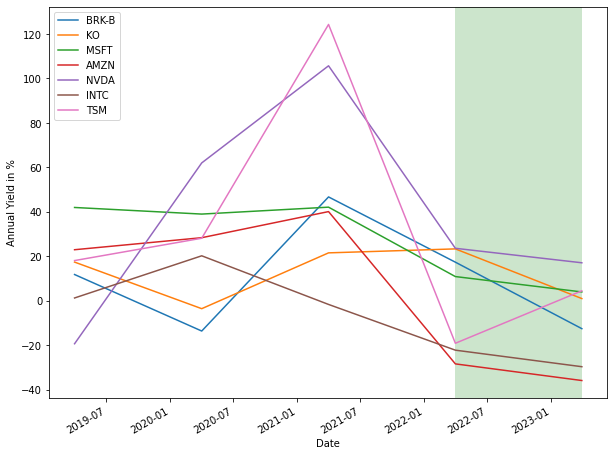

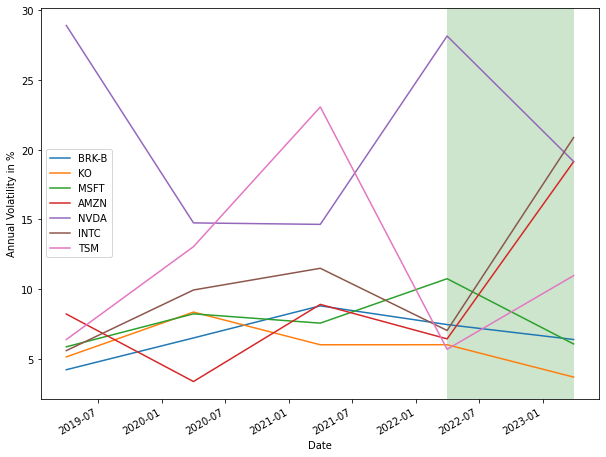

In [4]:
# Define the tickers to retrieve data for
syms = ['BRK-B', 'KO', 'MSFT', 'AMZN', 'NVDA', 'INTC', 'TSM']
tickers = [yf.Ticker(sym) for sym in syms]

create_plot_tickers(tickers,syms)